In [ ]:
!pip install dice_ml

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

import dice_ml

# Silence warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported!")

Libraries imported!


In [2]:
dataset_path = 'rideshare_kaggle.csv'

# Preprocessing the data

In [ ]:
df = pd.read_csv(dataset_path)

# Convert timestamp to datetime
df['datetime']= pd.to_datetime(df['datetime'])

# Feature Engineering
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.dayofweek # 0=Monday, 6=Sunday
df['month'] = df['datetime'].dt.month

# Select relevant features for our model
# We're keeping it simple for the workshop
features_to_use = [
    'price', 
    'distance', 
    'surge_multiplier', 
    'name',
    'hour', 
    'day', 
    'month',
    'temperature'
]
df_model = df[features_to_use].copy()

# 5. Clean data: Drop rows with missing price, impute temperature
df_model = df_model.dropna(subset=['price'])
df_model['temperature'] = df_model['temperature'].fillna(df_model['temperature'].mean())

print(f"Original data shape: {df.shape}")
print(f"Cleaned model data shape: {df_model.shape}")
df_model.head()

Original data shape: (50000, 57)
Cleaned model data shape: (46003, 8)


,price,distance,surge_multiplier,name,hour,day,month,temperature
441132,8.0,1.89,1.0,UberX,22,0,12,39.75
274010,13.5,1.97,1.0,Lyft XL,0,2,11,39.13
194181,13.5,1.23,1.0,Lux,5,5,12,45.18
197807,27.5,4.28,1.0,Lux,10,4,11,29.68
553729,31.5,2.34,1.0,Black SUV,17,0,12,37.71


## Split the data and standardize and OHE the features

In [4]:
# Define categorical and numeric features
categorical_features = ['name', 'hour', 'day', 'month']
numeric_features = ['distance', 'surge_multiplier', 'temperature']

# Define our target
TARGET = 'price'

# Split data
X = df_model.drop(TARGET, axis=1)
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a preprocessor
# OneHotEncoder for categoricals, StandardScaler for numerics
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # In case we add features
)

# Fit the preprocessor on training data and transform
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

one_hot_encoder = preprocessor.named_transformers_['cat']
ohe_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)
print("Features after OHE:")
print(ohe_feature_names)

X_train_scaled=X_train_scaled.toarray()
X_test_scaled=X_test_scaled.toarray()

# Get feature names after transformation (IMPORTANT for XAI)
feature_names = numeric_features + \
                list(preprocessor.named_transformers_['cat'] \
                                    .get_feature_names_out(categorical_features))

print(f"Total features after encoding: {len(feature_names)}")
print(feature_names)

Features after OHE:
['name_Black' 'name_Black SUV' 'name_Lux' 'name_Lux Black'
 'name_Lux Black XL' 'name_Lyft' 'name_Lyft XL' 'name_Shared'
 'name_UberPool' 'name_UberX' 'name_UberXL' 'name_WAV' 'hour_0' 'hour_1'
 'hour_2' 'hour_3' 'hour_4' 'hour_5' 'hour_6' 'hour_7' 'hour_8' 'hour_9'
 'hour_10' 'hour_11' 'hour_12' 'hour_13' 'hour_14' 'hour_15' 'hour_16'
 'hour_17' 'hour_18' 'hour_19' 'hour_20' 'hour_21' 'hour_22' 'hour_23'
 'day_0' 'day_1' 'day_2' 'day_3' 'day_4' 'day_5' 'day_6' 'month_11'
 'month_12']
Total features after encoding: 48
['distance', 'surge_multiplier', 'temperature', 'name_Black', 'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_UberPool', 'name_UberX', 'name_UberXL', 'name_WAV', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'h

# Linear Regression Model (White Box)

In [5]:
# Train the model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Show metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Linear Regression (White Box) ---")
print(f"Mean Squared Error: {mse_lr:.2f}")
print(f"R^2 Score: {r2_lr:.2f}")
#Print MAPE
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100
print(f"MAPE: {mape_lr:.2f}%")

--- Linear Regression (White Box) ---
Mean Squared Error: 6.04
R^2 Score: 0.93
MAPE: 13.52%


<Figure size 1000x1000 with 0 Axes>

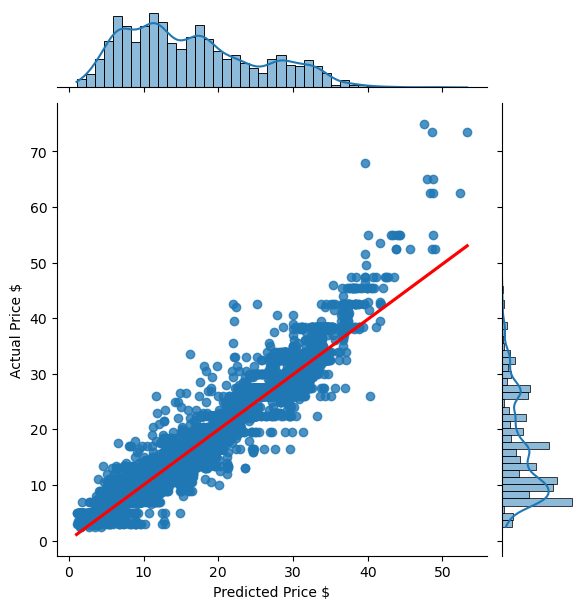

In [6]:
#Scatter plot the linear regression model predictions vs actual prices
plt.figure(figsize=(10, 10))
sns.jointplot(x=y_pred_lr, y=y_test,kind='reg',joint_kws={'line_kws': {'color': 'red'}})
plt.xlabel('Predicted Price $')
plt.ylabel('Actual Price $')
plt.show()

In [7]:
#Print equation of the linear regression model
print("Linear Regression Equation:")
eqn = f"price = {lr_model.intercept_:.2f} + "
for feat_name,coef in zip(feature_names,lr_model.coef_):
    eqn += f"{coef:.2f} * {feat_name} + "
print(eqn.strip(' + '))

Linear Regression Equation:
price = 16.54 + 3.19 * distance + 1.68 * surge_multiplier + -0.00 * temperature + 4.25 * name_Black + 13.98 * name_Black SUV + 0.77 * name_Lux + 6.00 * name_Lux Black + 15.38 * name_Lux Black XL + -7.34 * name_Lyft + -1.62 * name_Lyft XL + -10.29 * name_Shared + -7.58 * name_UberPool + -6.48 * name_UberX + -0.58 * name_UberXL + -6.49 * name_WAV + -0.02 * hour_0 + 0.08 * hour_1 + 0.14 * hour_2 + 0.06 * hour_3 + -0.04 * hour_4 + 0.04 * hour_5 + 0.04 * hour_6 + 0.06 * hour_7 + -0.10 * hour_8 + 0.01 * hour_9 + -0.09 * hour_10 + 0.03 * hour_11 + -0.01 * hour_12 + -0.02 * hour_13 + 0.05 * hour_14 + -0.06 * hour_15 + 0.01 * hour_16 + 0.12 * hour_17 + -0.02 * hour_18 + 0.01 * hour_19 + -0.04 * hour_20 + -0.09 * hour_21 + -0.07 * hour_22 + -0.10 * hour_23 + 0.02 * day_0 + 0.01 * day_1 + -0.00 * day_2 + 0.03 * day_3 + -0.03 * day_4 + -0.01 * day_5 + -0.01 * day_6 + -0.01 * month_11 + 0.01 * month_12


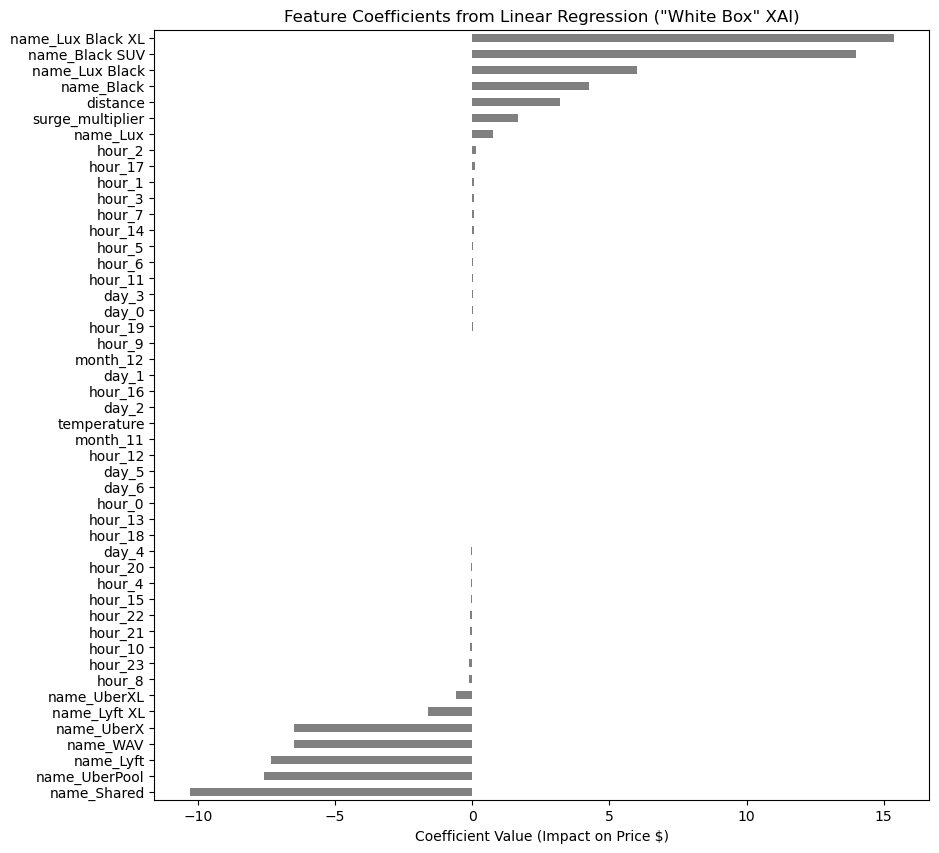

In [ ]:
#TODO: Plot coefficients to determine feature importance


# Keras Neural Network (Black-box model)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113 (8.25 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 0 (0.00 B)


Training Keras 'Black Box' model...
Epoch 1/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - loss: 43.3134 - mse: 43.3134  
Epoch 2/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - loss: 4.4241 - mse: 4.4241
Epoch 3/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 3.8457 - mse: 3.8457
Epoch 4/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 3.6807 - mse: 3.6807
Epoch 5/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 3.5955 - mse: 3.5955
Epoch 6/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 3.5477 - mse: 3.5477
Epoch 7/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 3.5155 - mse: 3.5155
Epoch 8/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 3.4927 - mse: 3.4927
Epoch 9/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 3.4745 - mse: 3.4745
Epoch 10/10
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 3.4596 - mse: 3.4596
Training complete.


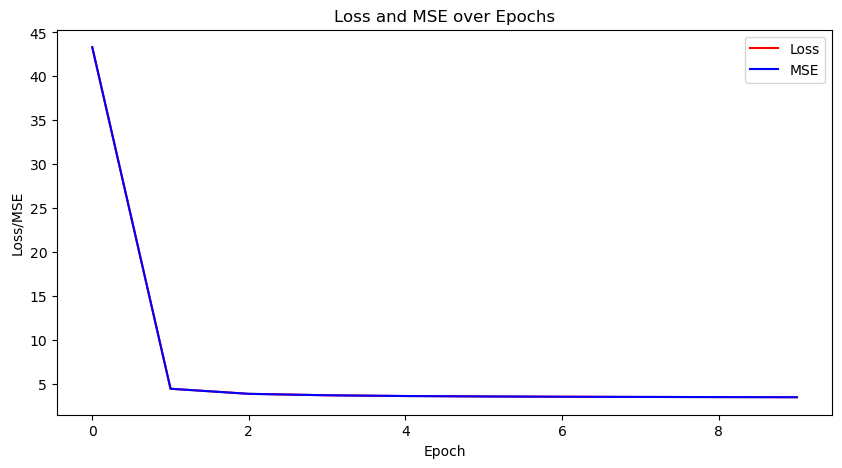

In [ ]:
def build_keras_model(input_shape=46):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1) # Output layer: a single number (price)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse', # Mean Squared Error
        metrics=['mse']
    )
    return model

# Build the model
input_shape = X_train_scaled.shape[1]

keras_model = build_keras_model(input_shape)
keras_model.summary()


# Train the model (fast, for the workshop)
print("\nTraining Keras 'Black Box' model...")
history = keras_model.fit(
    X_train_scaled,
    y_train,
    epochs=10,
    batch_size=32,
)

print("Training complete.")
#Plot the loss and mse over epochs from history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss',color='red')
plt.plot(history.history['mse'], label='MSE',color='blue')
plt.title('Loss and MSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss/MSE')
plt.legend()
plt.show()

In [10]:
# Make predictions
y_pred_keras = keras_model.predict(X_test_scaled).flatten()

# Show metrics
mse_keras = mean_squared_error(y_test, y_pred_keras)
r2_keras = r2_score(y_test, y_pred_keras)
#Find MAPE
mape_keras = np.mean(np.abs((y_test - y_pred_keras) / y_test)) * 100

print("\n--- Keras NN (Black Box) ---")
print(f"Mean Squared Error: {mse_keras:.2f}")
print(f"R^2 Score: {r2_keras:.2f}")
print(f"MAPE: {mape_keras:.2f}%")

print("\n--- Comparison ---")
print(f"Linear Regression R^2: {r2_lr:.2f}")
print(f"Keras NN R^2:          {r2_keras:.2f}")
print()
print(f"Linear Regression MSE: {mse_lr:.2f}")
print(f"Keras NN MSE:          {mse_keras:.2f}")
print()
print(f"Linear Regression MAPE: {mape_lr:.2f}%")
print(f"Keras NN MAPE:          {mape_keras:.2f}%")

288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step

--- Keras NN (Black Box) ---
Mean Squared Error: 3.51
R^2 Score: 0.96
MAPE: 9.09%

--- Comparison ---
Linear Regression R^2: 0.93
Keras NN R^2:          0.96

Linear Regression MSE: 6.04
Keras NN MSE:          3.51

Linear Regression MAPE: 13.52%
Keras NN MAPE:          9.09%


# XAI Pt1 - Explain a prediction using Integrated Gradients

In [ ]:
#TODO: Implement Integrated Gradients helper functions (interpolate_features and compute_gradients)










#Helper to plot the bar chart for attributions
def plot_attributions(attributions, feature_names, title=""):
    """Helper to plot the bar chart for attributions."""
    attributions = pd.Series(attributions, index=feature_names)
    
    # Filter out zero-importance features to make the plot cleaner
    attributions = attributions[attributions != 0].sort_values()
    
    plt.figure(figsize=(10, 10))
    attributions.plot(kind='barh', color=attributions.apply(lambda x: 'green' if x > 0 else 'red'))
    plt.title(title)
    plt.xlabel("Attribution (Impact on Price $)")
    plt.show()

In [ ]:
# Select a target ride to explain
# Let's find an expensive one
test_prices = pd.Series(y_pred_keras)
expensive_ride_idx = test_prices.idxmax()

target_features = tf.convert_to_tensor(X_test_scaled[expensive_ride_idx], dtype=tf.float32)
target_price = y_test.iloc[expensive_ride_idx]
model_price = y_pred_keras[expensive_ride_idx]

print(f"Explaining ride index: {expensive_ride_idx}")
print(f"Actual Price: ${target_price:.2f}")
print(f"Model's Predicted Price: ${model_price:.2f}\n")

Explaining ride index: 3999
Actual Price: $73.50
Model's Predicted Price: $71.80



In [13]:
#Features of the ride to investigate:
X_test.iloc[expensive_ride_idx]

distance                     4.8
surge_multiplier            1.75
name                Lux Black XL
hour                           5
day                            6
month                         12
temperature                 40.3
Name: 170802, dtype: object

In [ ]:
#TODO: Create a baseline (the "average ride")





tf.Tensor(
[ 2.69467862e-16 -3.59941908e-15  1.01000672e-17  8.82560760e-02
  8.54573101e-02  7.87185505e-02  8.32019970e-02  7.92619959e-02
  8.03217217e-02  7.86913782e-02  8.05934444e-02  8.69789720e-02
  8.66528973e-02  8.71148333e-02  8.47508311e-02  4.51877601e-02
  4.20901030e-02  4.28509302e-02  3.96174118e-02  4.01336886e-02
  3.59219611e-02  3.88294123e-02  3.62480283e-02  3.39383744e-02
  4.17640358e-02  4.30683121e-02  4.28781062e-02  4.27694134e-02
  4.57040370e-02  4.40465175e-02  4.44269329e-02  4.20629308e-02
  4.37747948e-02  4.66822460e-02  3.98619622e-02  3.96445841e-02
  4.06499654e-02  4.13564481e-02  4.64920402e-02  1.80588007e-01
  1.77137107e-01  1.07276775e-01  1.45100817e-01  1.29857078e-01
  1.29612520e-01  1.30427688e-01  4.14950281e-01  5.85049748e-01], shape=(48,), dtype=float32)


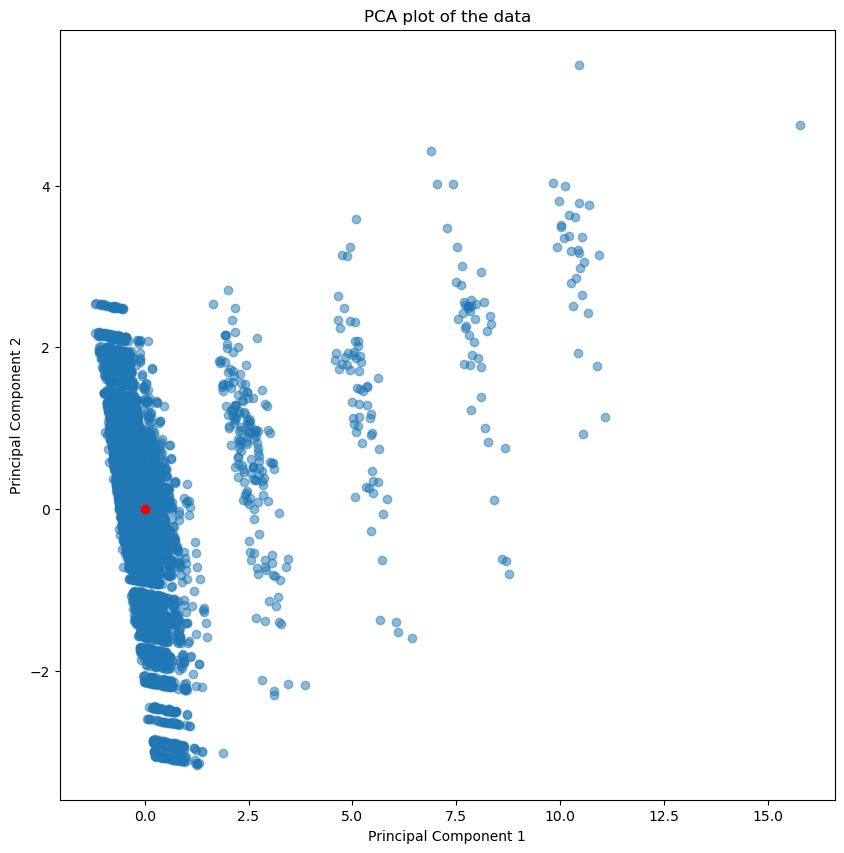

In [ ]:
#Plot the data in 2D scatter plot using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
#Plot the baseline point in red so we can all see it
plt.scatter(baseline[0], baseline[1], color='black')
#Plot the target point in blue so we can all see it
plt.scatter(X_pca[expensive_ride_idx, 0], X_pca[expensive_ride_idx, 1], color='red')
#Draw a straight line from baseline to target
plt.plot([baseline[0], X_pca[expensive_ride_idx, 0]], [baseline[1], X_pca[expensive_ride_idx, 1]], color='gray', linestyle='--')
plt.title("PCA plot of the data")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
#TODO: Implent Integrated Gradients - interpolation path



In [ ]:
#TODO: Implent Integrated Gradients




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Baseline Price (average ride): $13.93
Model Predicted Price: $71.80
Difference (what IG explains): $57.87
Sum of IG Attributions: $57.58
Approximation error: $0.289

Note: IG explains why the price is $57.87 above the baseline,
      not why the absolute price is $71.80.


In [ ]:
# Check the "Completeness" property (The pro-level insight)
# IMPORTANT: Integrated Gradients explains the DIFFERENCE from baseline,
# NOT the absolute prediction. The baseline represents the "average ride"
# and IG attributes how each feature contributes to moving from baseline to prediction.
difference = model_price - baseline_price
sum_of_attributions = tf.reduce_sum(ig_attributions)

print(f"Baseline Price (average ride): ${baseline_price:.2f}")
print(f"Model Predicted Price: ${model_price:.2f}")
print(f"Difference (what IG explains): ${difference:.2f}")
print(f"Sum of IG Attributions: ${sum_of_attributions:.2f}")
print(f"Approximation error: ${abs(difference - sum_of_attributions):.3f}")
print(f"\nNote: IG explains why the price is ${difference:.2f} above the baseline,")
print(f"      not why the absolute price is ${model_price:.2f}.")

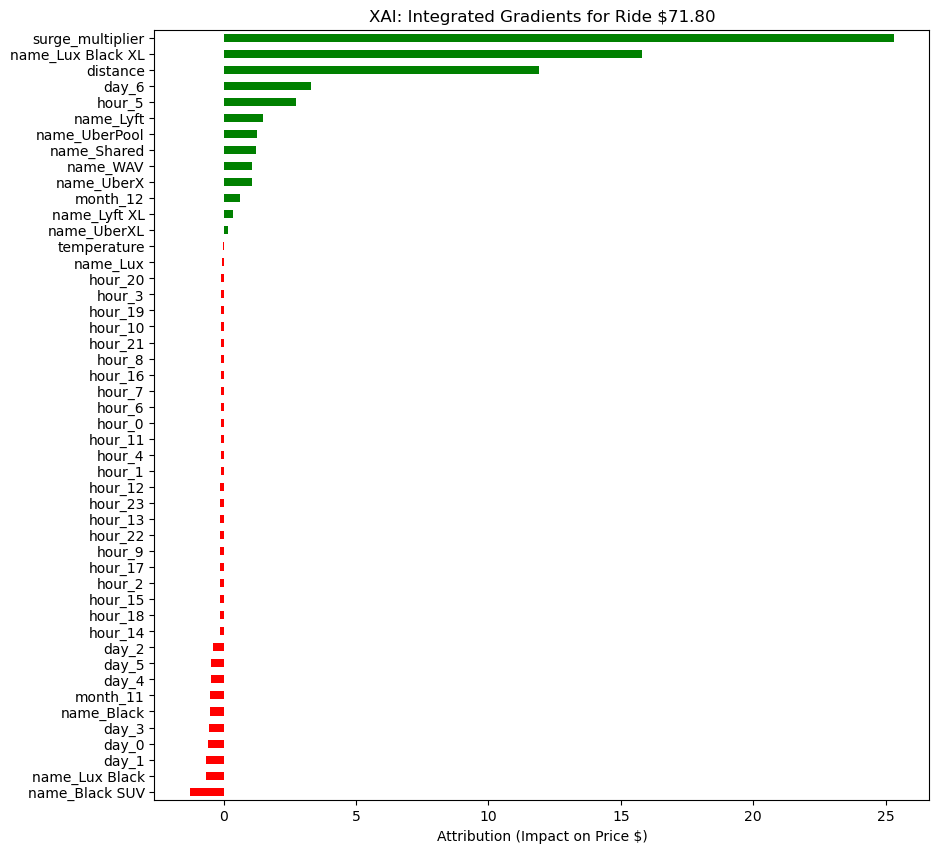

In [ ]:
#TODO: plot the attributions




In [18]:
#Print ig_attributions with their column names
print(pd.DataFrame(ig_attributions.numpy(), index=feature_names,columns=['$ Contribution']).sort_values(by='$ Contribution', ascending=False))

                   $ Contribution
surge_multiplier        25.323322
name_Lux Black XL       15.781359
distance                11.915914
day_6                    3.295168
hour_5                   2.726021
name_Lyft                1.479415
name_UberPool            1.260012
name_Shared              1.235399
name_WAV                 1.088204
name_UberX               1.063851
month_12                 0.626949
name_Lyft XL             0.340434
name_UberXL              0.150487
temperature             -0.003644
name_Lux                -0.073575
hour_20                 -0.090899
hour_3                  -0.093311
hour_19                 -0.094473
hour_10                 -0.096807
hour_21                 -0.097616
hour_8                  -0.103339
hour_16                 -0.103984
hour_7                  -0.105215
hour_6                  -0.108362
hour_0                  -0.109017
hour_11                 -0.110211
hour_4                  -0.112222
hour_1                  -0.113145
hour_12       

# XAI Pt2 - Alternate features to get desired prediction using DiCE

In [ ]:
class KerasWrapper:
    """
    A wrapper class to make a Keras model with a separate 
    sklearn preprocessor look like a single sklearn model.
    DiCE's 'sklearn' backend can then use its .predict() method.
    """
    def __init__(self, model, preprocessor):
        self.model = model
        self.preprocessor = preprocessor

    def predict(self, raw_df):
        # DiCE sends a raw DataFrame (e.g., with 'Lux Black XL')
        # Preprocess this raw data using your fitted preprocessor
        scaled_data = self.preprocessor.transform(raw_df)
        
        # Ensure it's a dense array for Keras
        if not isinstance(scaled_data, np.ndarray):
            scaled_data = scaled_data.toarray()
            
        # Get predictions from the actual Keras model
        predictions = self.model.predict(scaled_data)
        
        # Return the flattened predictions
        return predictions.flatten()

In [ ]:
#TODO: Create wrapped model object




#TODO: Create the DiCE Data object



#TODO: Create the DiCE Model object



#TODO: Initialize DiCE




#TODO: Prep query & generate counterfactuals




#TODO: Extract and print the counterfactuals


--- XAI: Counterfactuals with DiCE ---

Querying for counterfactuals to price (20, 50)...
Original Predicted Price: $71.80

Original Ride (raw features):


,distance,surge_multiplier,name,hour,day,month,temperature
170802,4.8,1.75,Lux Black XL,5,6,12,40.3


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


--- XAI: DiCE Counterfactual Results (Human-Readable) ---

Counterfactuals (How to get a cheaper ride):


,distance,surge_multiplier,temperature,name,hour,day,month,NEW_PRICE (Predicted)
2,4.800000,1.75,40.3,"Lux Black XL,Lyft",5,6,12,50.0
4,4.800000,1.75,40.3,"Lux Black XL,Lyft",5,6,12,50.0
0,4.800000,1.75,40.3,Black,5,6,12,47.0
1,4.800000,1.75,40.3,Black,5,6,12,47.0
3,0.261381,1.75,40.3,Lux Black XL,5,6,12,41.0
